In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N_CUTPOINTS = 3

cutpoints = [0] + list(np.cumsum(np.exp(np.random.randn(N_CUTPOINTS) + 1))) + [1000]
cutpoints

[0, 6.170924645299267, 8.219188258657223, 15.831907914482539, 1000]

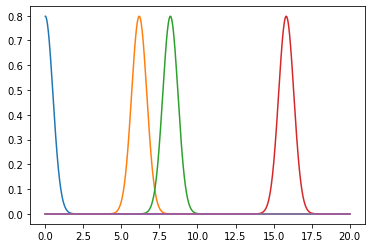

In [3]:
from scipy.stats import norm

SCALE = .5

x = np.linspace(0, 20, 1000)

for pt in cutpoints:
    plt.plot(x, norm.pdf(x, loc=pt, scale=SCALE))
    
plt.show()

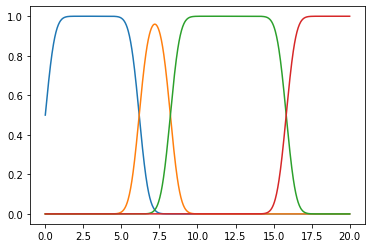

In [4]:
for pt1, pt2 in zip(cutpoints[:-1], cutpoints[1:]):
    plt.plot(x, norm.cdf(x, loc=pt1, scale=SCALE) * (1 - norm.cdf(x, loc=pt2, scale=SCALE)))

plt.show()

In [7]:
logtimes = list(np.random.randn(N_CUTPOINTS + 1) + .7)
logtimes

[0.957536961876204,
 0.49262026679732673,
 1.3471918865416859,
 1.2895345105201352]

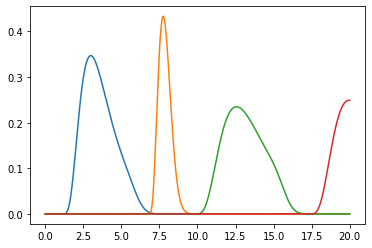

In [8]:
from scipy.stats import lognorm

for pt1, pt2, logtime in zip(cutpoints[:-1], cutpoints[1:], logtimes):
    pdf = lognorm.pdf(x - pt1, s=SCALE, loc=logtime, scale=np.exp(logtime))
    pdf *= norm.cdf(x, loc=pt1, scale=SCALE)
    pdf *= (1 - norm.cdf(x, loc=pt2, scale=SCALE))
    plt.plot(x, pdf)
    
plt.show()

## Note: these are not valid densities
- they are close, potentially, but multiplying by the cdf and survival curves throws things off

In [23]:
import pandas as pd

df = pd.read_csv('../data/melanoma.csv', index_col=0)
df.tail()

,time,status,sex,age,year,thickness,ulcer
201,4492,2,1,29,1965,7.06,1
202,4668,2,0,40,1965,6.12,0
203,4688,2,0,42,1965,0.48,0
204,4926,2,0,50,1964,2.26,0
205,5565,2,0,41,1962,2.90,0


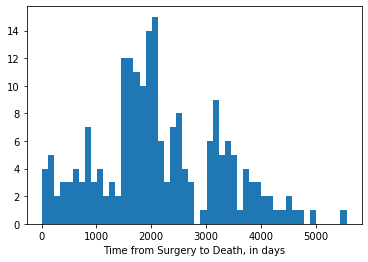

In [10]:
plt.hist(df['time'], bins=50)
plt.xlabel('Time from Surgery to Death, in days')
plt.show()

In [60]:
n_train = 4 * len(df) // 5

x_train = df.loc[:, 'status':].values[:n_train, :].astype(float)
y_train = df['time'].values[:n_train].astype(float)

x_test = df.loc[:, 'status':].values[n_train:, :].astype(float)
y_test = df['time'].values[n_train:].astype(float)

x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
x_test = (x_test - x_train.mean(axis=0)) / x_train.std(axis=0)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(164, 6) (164,) (41, 6) (41,)


In [13]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [98]:
def lognormal_nlogpdf(t, mu, logvar, epsilon=1e-4):

    logt = tf.math.log(tf.math.maximum(t, 0) + epsilon)
    scale = tf.math.exp(0.5 * logvar)

    normal_dist = tfd.Normal(loc=mu, scale=scale)
    
    return logt - normal_dist.log_prob(logt)

In [136]:
import tensorflow as tf

tf.keras.backend.set_floatx('float64')

N_COMPONENTS = 3
GGE_T = 10000
MAX_T = df['time'].max()
CUTPOINT_SCALE = 300.

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


class SimplePETM(Model):
    
    def __init__(self):
        
        super(SimplePETM, self).__init__()
        self.mu = Dense(N_COMPONENTS, kernel_initializer='zeros')
        self.logvar = Dense(N_COMPONENTS, kernel_initializer='zeros')
        self.logits = Dense(N_COMPONENTS)
        self.cutpoints = tf.Variable(np.ones(N_COMPONENTS - 1) * MAX_T / N_COMPONENTS)
        #self.cutpoints = tf.constant([1400., 1600.], dtype=tf.float64)
        
        # need to add prior to cutpoints

    def call(self, x):
        
        # components
        logits = self.logits(x)
        pi = tf.nn.softmax(logits)
        
        # time to event
        mu = self.mu(x)
        logvar = self.logvar(x)
        
        # cutpoints
        cutpoints = tf.math.cumsum(self.cutpoints)
        
        return pi, mu, logvar, cutpoints

    
def compute_loss(pi, mu, logvar, cutpoints, t):
    
    zero_and_cutpoints = tf.concat([[0], cutpoints], axis=0)
    cutpoints_and_inf = tf.concat([cutpoints, [GGE_T]], axis=0)
    
    t_all = t[:, tf.newaxis] - zero_and_cutpoints[tf.newaxis, :]
    
    nlogpdf = lognormal_nlogpdf(t_all, mu, logvar)
    nlogcdf = -1 * tfd.Normal(loc=zero_and_cutpoints, scale=CUTPOINT_SCALE).log_cdf(t[:, tf.newaxis])
    nlogsurv = -1 * tfd.Normal(loc=cutpoints_and_inf, scale=CUTPOINT_SCALE).log_survival_function(t[:, tf.newaxis])
    
    # all above have shape (n_samples, n_components)
    
    return tf.reduce_mean(tf.reduce_sum(pi * (nlogpdf + nlogcdf + nlogsurv), axis=1))
    

model = SimplePETM()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [137]:
@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        pi, mu, logvar, cutpoints = model(x, training=True)
        print(cutpoints)
        loss = compute_loss(pi, mu, logvar, cutpoints, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    
@tf.function
def test_step(x, t):
    pi, mu, logvar, cutpoints = model(x, training=False)
    t_loss = compute_loss(pi, mu, logvar, cutpoints, t)

    test_loss(t_loss)

In [138]:
EPOCHS = 5

tf.config.experimental_run_functions_eagerly(True)

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        train_step(x, y)

    for x, y in test_ds:
        test_step(x, y)
        
    print('Epoch %i, Loss: %.3e, Test Loss: %.3e' % (
        (epoch + 1),
        train_loss.result(),
        test_loss.result()))

tf.Tensor([1855. 3710.], shape=(2,), dtype=float64)
tf.Tensor([1854.99900052 3709.99800093], shape=(2,), dtype=float64)
tf.Tensor([1854.99814607 3709.99614893], shape=(2,), dtype=float64)
tf.Tensor([1854.99836476 3709.99537503], shape=(2,), dtype=float64)
tf.Tensor([1854.99846732 3709.9944849 ], shape=(2,), dtype=float64)
tf.Tensor([1854.99850437 3709.9935332 ], shape=(2,), dtype=float64)
Epoch 1, Loss: 4.539e+01, Test Loss: 4.482e+01
tf.Tensor([1854.99862225 3709.9926591 ], shape=(2,), dtype=float64)
tf.Tensor([1854.99902661 3709.9920776 ], shape=(2,), dtype=float64)
tf.Tensor([1854.99921228 3709.99128749], shape=(2,), dtype=float64)
tf.Tensor([1854.99938234 3709.99049028], shape=(2,), dtype=float64)
tf.Tensor([1854.9994985  3709.98964273], shape=(2,), dtype=float64)
tf.Tensor([1854.99951917 3709.98868539], shape=(2,), dtype=float64)
Epoch 2, Loss: 4.286e+01, Test Loss: 4.845e+01
tf.Tensor([1854.99948144 3709.98769763], shape=(2,), dtype=float64)
tf.Tensor([1854.99973922 3709.987011  